# Визуализация данных с помощью Seaborn

Цель задания - исследование датасета dataset_file_storage.csv и визуализация данных с помощью Seaborn.

Для каждой задачи необходимо:

- Построить график-гистограмму (размер графика должен быть достаточным для визуального анализа).

- Подписать оси и заголовок.

- Ответить на поставленные вопросы.
___________

- Код должен выполняться при условии наличия датасета в каталоге со скриптом или указанием пути к датасету (падение кода с ошибкой у проверяющего на python аналогичной версии - повод не зачесть все пункты соответствующей задачи).

Описание полей датасета:
- ProjectID (число) - id проекта в рамках которого загружен файл, привязка к элементам другой таблицы
- UserID (число) - id пользователя, загрузившего файл, привязка к элементам другой таблицы
- uploadServerUnixTime (число) - время загрузки файла на сервер в формате UnixTime
- CompanyID (число) - id организации которой принадлежит пользователь, привязка элемента другой таблицы
- FileSize (число) - размер файла в байтах
- TypeDocs (строка) - раздел в который загружен файл
    
Для общего понимания архитектуры датасета:
Есть организации-застройщики (CompanyID), в каждой из которых может быть несколько пользователей (UserID).
Существуют проекты (ProjectID), к каждому из которых может иметь доступ несколько пользователей разных организаций (пользователь может иметь доступ к нескольким проектам).
Внутри каждого проекта есть несколько разделов (TypeDocs), в который пользователь загружает файлы для организации.

Перед выполнением заданий необходимо импортировать требуемые для работы модули Python, загрузить датасет в датафрейм и выполнить его предварительную обработку:
- очистить датафрейм от неполных данных (есть записи за неполный месяц март);
- преобразовать столбец "uploadServerUnixTime" в пригодный для работы формат с помощь методов модуля datetime;
- на основе столбца "uploadServerUnixTime" добавить необходимые столбцы для группировки данных (месяц, день и т.п

Пожелания при выполнении заданий (они не влияют на итоговую оценку):
- постарайтесь оформить как функцию вывод однотипных графиков и вызывать её в нужных местах;
- для облегчения понимания написанного кода добавлять к нему комментарии.

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import datetime
%matplotlib inline
sns.set()

df = pd.read_csv('dataset_file_storage.csv', sep=';')
df['uploadServerUnixTime'] = df['uploadServerUnixTime'].astype('datetime64[s]')
df = df.sort_values('uploadServerUnixTime')
df = df.rename(columns={'uploadServerUnixTime': 'Date'})
df = df[df['Date'] < '2020-03-01']
# df['Month'] = df['Date'].dt.month
# df['Day'] = df['Date'].dt.day
df.head(5)

,ProjectID,UserID,Date,CompanyID,FileSize,TypeDocs
35,705605,26912,2019-10-10 07:20:10,703124,239262494,1.Основные документы
4,705605,26912,2019-10-11 13:06:50,703124,1030735,1.Основные документы
5,705605,26912,2019-10-11 13:26:04,703124,1030735,1.Основные документы
23,705605,26912,2019-10-11 14:06:37,703124,4,1.Основные документы
209,705605,26912,2019-10-14 07:00:20,703124,4,2.Технические условия


## Задание №1

### Задание 1.1
Постройте накопительный график/гистограмму суммарного объёма загруженных файлов по дням (используйте логарифмическую шкалу для объёма).

[None]

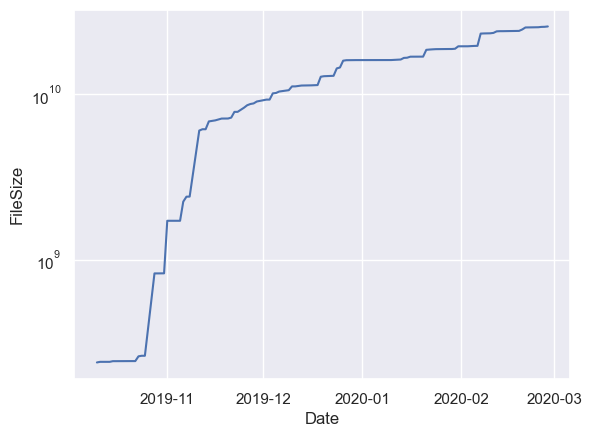

In [119]:
group = df.groupby([df['Date'].dt.date])['FileSize'].sum().cumsum()
g = sns.lineplot(group)
g.set(yscale='log')

### Задание 1.2
Какой прогноз можно дать по объему файлового хранилища на конец 2020?

In [120]:
cumsum_by_day = group.reset_index()

cumsum_by_day['Date'] = cumsum_by_day['Date'].astype('datetime64[ns]')

last_day_file_size = cumsum_by_day[cumsum_by_day['Date'] == '2020-02-28']
first_day_file_size = cumsum_by_day[cumsum_by_day['Date'] == '2020-02-03']

timedelta = last_day_file_size['Date'].iloc[0] - first_day_file_size['Date'].iloc[0]

month_file_size = last_day_file_size['FileSize'].iloc[0] - first_day_file_size['FileSize'].iloc[0]

avg_month_file_size = month_file_size / timedelta.days

last_year_day_df = pd.DataFrame({'Date': ['2020-12-31'],
                                 'FileSize': [None]})
last_year_day_df['Date'] = last_year_day_df['Date'].astype('datetime64[ns]')

timedelta_to_last_year_day = last_year_day_df['Date'].iloc[0] - last_day_file_size['Date'].iloc[0]
expected_file_size = timedelta_to_last_year_day.days * avg_month_file_size + last_day_file_size['FileSize'].iloc[0]

print(f'На конец года можно ожидать объём хранилища = {expected_file_size}')

На конец года можно ожидать объём хранилища = 101415410371.88


### Задание 1.3
На основании прогноза постройте накопительный график/гистограмму суммарного объёма загруженных файлов помесячно: первые месяцы будут реальные данные, а далее, начиная с марта - прогнозируемый объем. (Подсказка: для более точного прогноза месячного прироста суммарного объема файлов исключите из анализа месяцы с неполными данными.)

[None]

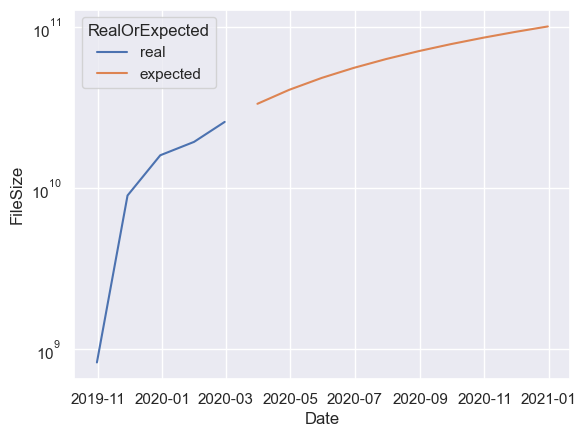

In [121]:

expected_df = pd.DataFrame(pd.date_range(last_day_file_size['Date'].iloc[0] + pd.DateOffset(days=1), last_year_day_df['Date'].iloc[0]), columns=['Date'])

expected_df['FileSize'] = (expected_df['Date'] - last_day_file_size['Date'].iloc[0]).dt.days * avg_month_file_size + last_day_file_size['FileSize'].iloc[0]

cumsum_by_day['RealOrExpected'] = 'real'
expected_df['RealOrExpected'] = 'expected'

with_expected = pd.concat([cumsum_by_day, expected_df], ignore_index=True)

# group_with_expected = with_expected.groupby([with_expected['Date'].dt.month])['FileSize'].sum()
with_expected['year_month'] = with_expected['Date'].dt.to_period('M')
group_with_expected = with_expected.groupby('year_month', as_index=False).max()

g = sns.lineplot(group_with_expected, x='Date', y='FileSize', hue='RealOrExpected')
g.set(yscale='log')

## Задание №2
Постройте 2 гистограммы:
-	Распределения количества файлов по дням недели
-	Распределения количества файлов по часам

<Axes: xlabel='Day', ylabel='FileSize'>

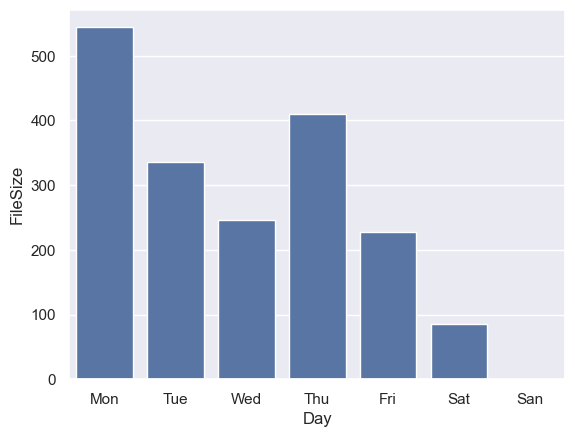

In [141]:
grouped_by_dayofweek = df.groupby([df['Date'].dt.dayofweek])['FileSize'].count()

days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'San']
days_of_week_df = pd.Series(days_of_week)
days_of_week_df.name = 'Day'

grouped_by_dayofweek_named = pd.merge(grouped_by_dayofweek, days_of_week_df, left_index=True, right_index=True, how='right')

sns.barplot(grouped_by_dayofweek_named, x='Day', y='FileSize')

<Axes: xlabel='Hour', ylabel='FileSize'>

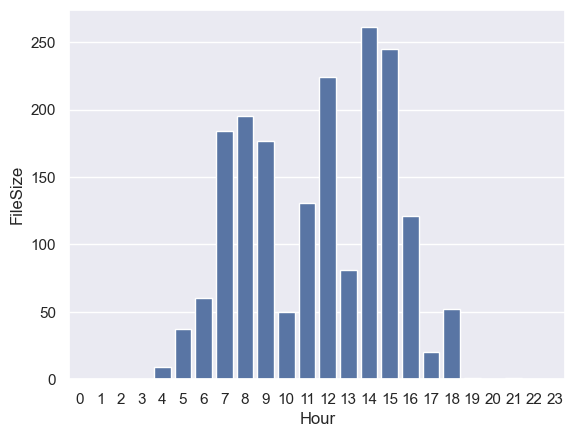

In [142]:
grouped_by_hours = df.groupby([df['Date'].dt.hour])['FileSize'].count()
all_hours_df = pd.Series(np.arange(24))
all_hours_df.name = 'Hour'

grouped_by_hours_named = pd.merge(grouped_by_hours, all_hours_df, left_index=True, right_index=True, how='right')

sns.barplot(grouped_by_hours_named, x='Hour', y='FileSize')

### Задание 2.1 (дополнительное для отличников)
На основании построенных гистограмм какие выводы можно сделать?

Выводы:
1. Работы с загрузкой файлов производятся в основном в будние дни. В понедельник больше всего загрузок
2. Пользователи активно загружают файлы с 7 до 9, потом у них видимо кофе-пауза, потом опять активничают с 11 до 12, потом видимо обед, а потом опять проявляется активность с 14 до 16.

## Задание №3
Постройте 2 гистограммы:
- Распределения количества файлов в зависимости от раздела.
- Постройте ящики с усами для среднего количества файлов в проекте в зависимости от раздела.

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, '1.Основные документы'),
  Text(1, 0, '2.Технические условия'),
  Text(2, 0, '3.Материалы для KYC'),
  Text(3, 0, '4.Презентация по проекту'),
  Text(4, 0, '5.Финансовые документы'),
  Text(5, 0, '6.Юридические документы'),
  Text(6, 0, '7.Cмешанный проект'),
  Text(7, 0, '8.Другие документы')])

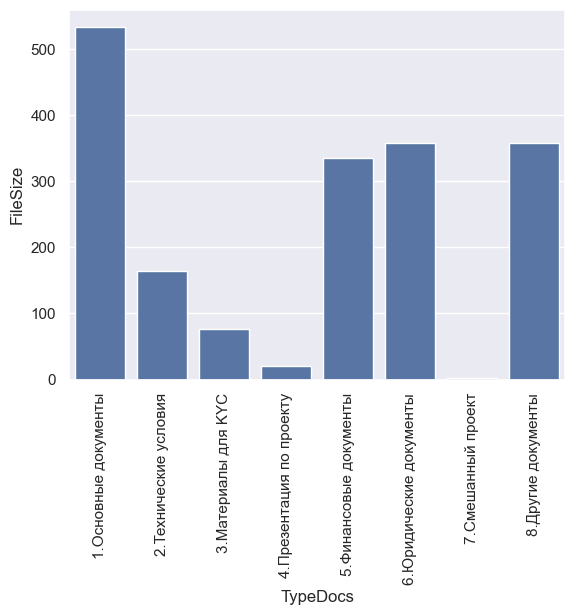

In [148]:
grouped_by_type = df.groupby([df['TypeDocs']])
sns.barplot(grouped_by_type['FileSize'].count())
plt.xticks(rotation=90)

In [151]:
grouped_by_project_and_type = df.groupby(['ProjectID', 'TypeDocs']).count()
grouped_by_project_and_type

UserID  Date  CompanyID  FileSize
ProjectID TypeDocs                                                  
705605    1.Основные документы         13    13         13        13
          2.Технические условия         3     3          3         3
          3.Материалы для KYC           2     2          2         2
          5.Финансовые документы        7     7          7         7
          6.Юридические документы       2     2          2         2
...                                   ...   ...        ...       ...
755110    1.Основные документы          9     9          9         9
          2.Технические условия        23    23         23        23
          5.Финансовые документы       36    36         36        36
          6.Юридические документы       7     7          7         7
          8.Другие документы           13    13         13        13

[133 rows x 4 columns]

### Задание 3.1 (дополнительное для отличников)
Какие рекомендации можно дать по создания/удалению разделов?

# *Дальше я уже не вывожу (((((((((*

## Задание №4
Постройте гистограмму суммарного объёма файлов по проектам (используйте логарифмическую шкалу для объёма).

## Задание №5
Постройте ящики с усами для размеров загружаемых файлов по компаниям.

### Задание 5.1 (дополнительное для отличников)
Можно ли сделать какие-то выводы о предпочтениях к большим/маленьким файлам в разных компаниях? Можно ли сделать практически полезные выводы для администраторов сервиса загрузки?

## Задание №6
Какие ещё графики вы построили для этих данных и какой вывод из этой иллюстрации можно сделать? Постройте ещё хотя бы 1 любой график/гистограмму/боксплот или иную иллюстрацию.